<a href="https://colab.research.google.com/github/anveshverma/Performace-comparison-between-CPU-and-GPU-on-Image-Processing-operations/blob/master/code_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import time
import math
import glob
from google.colab.patches import cv2_imshow
import numpy as np
import cupy as cp
import numba
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
 #!unzip images.zip

Archive:  images.zip
  inflating: 1024.jpg                
  inflating: 1800.jpg                
  inflating: 256.jpg                 
  inflating: 4000.jpg                
  inflating: 512.jpg                 


In [ ]:
def plot_comparison(d_s,d_p,title):
  plt.figure(figsize=(11,6))
  speedup = sum(d_s.values())/sum(d_p.values())
  print('Average Speedup:',str(int(speedup))+'x')
  x = sorted(list(map(int,d_s.keys())))
  y_s= [d_s[str(i)] for i in x]
  y_p= [d_p[str(i)] for i in x]
  labels = ['{}x{}'.format(i,i) for i in x]
  plt.plot(x,y_s,marker='o')
  plt.plot(x,y_p,marker='o')
  plt.xticks(x,labels,rotation=45)
  plt.xlabel('RESOLUTION')
  plt.ylabel('Time in ms')
  plt.legend(['Sequential','CUDA'])
  plt.title(title)
  plt.show



In [ ]:
def adj_show(a,b):
  dim = a.shape
  dim_border = (a.shape[0],30) if len(dim)==2 else (a.shape[0],30,3)
  cv2_imshow(np.concatenate((a,255*np.ones(dim_border),b),axis=1))

In [ ]:
images={}
for filename in glob.glob('*.jpg'):
    im=cv2.imread(filename)
    images[filename.split('.')[0]]=im
images.keys()

dict_keys(['256', '512', '4000', '1024', '1800'])

In [ ]:
lamb = 150
threshold = 150

In [ ]:
def grayscale_sequential(img):               #Sequential
  GI = []
  for i in range(img.shape[0]):
    l = []
    for j in range(img.shape[1]):
      l.append(sum(img[i][j])/3)
    GI.append(l)
  GI = np.array(GI)
  return GI

In [ ]:
@numba.njit('float64[:,:](uint8[:,:,:])')        #CUDA backend
def grayscale_parallel(img):
  return (img[:,:,0]+img[:,:,1]+img[:,:,2])/3

In [ ]:
#Calculating time (Sequential) - Grayscale
t_gray_seq = {}
out_gray_seq = {}
for name,image in images.items():
  start = time.time()
  out_gray_seq[name]=grayscale_sequential(image)
  t_gray_seq[name] =  time.time() - start
t_gray_seq

{'1024': 5.584137678146362,
 '1800': 17.580551147460938,
 '256': 0.35837507247924805,
 '4000': 86.82654666900635,
 '512': 1.375356674194336}

In [ ]:
#Calculating time (Parallel) - Grayscale
t_gray_p = {}
out_gray_p = {}
for name,image in images.items():
  start = time.time()
  out_gray_p[name]=grayscale_parallel(images[name])
  t_gray_p[name] =  time.time() - start
t_gray_p

{'1024': 0.004173994064331055,
 '1800': 0.012249946594238281,
 '256': 0.0006959438323974609,
 '4000': 0.09937477111816406,
 '512': 0.0009427070617675781}

Average Speedup: 951x


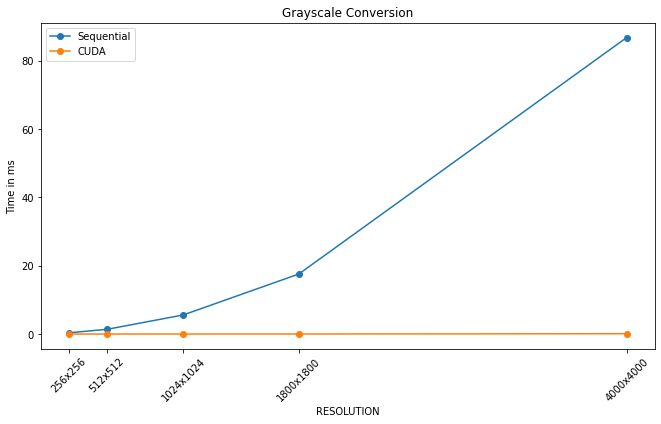

In [ ]:
plot_comparison(t_gray_seq,t_gray_p,'Grayscale Conversion')

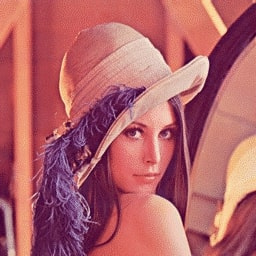

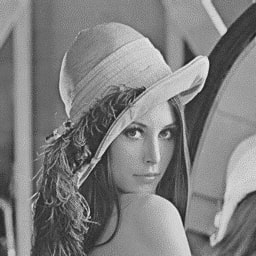

In [ ]:
cv2_imshow(images['256'])
cv2_imshow(out_gray_p['256'])

In [ ]:
def negative_sequential(img):         #Sequential
  NI = []
  for i in range(img.shape[0]):
    l = []
    for j in range(img.shape[1]):
      q = []
      for k in range(img.shape[2]):
        q.append(255-img[i][j][k])
      l.append(q)
    NI.append(l)
  NI = np.array(NI)
  return NI

In [ ]:
@numba.vectorize('uint8(uint8)',target='parallel')           #CUDA backend
def negative_parallel(img):
  return 255-img

In [ ]:
#Calculating time (Sequential) - Negative
t_neg_seq = {}
out_neg_seq = {}
for name,image in images.items():
  start = time.time()
  out_neg_seq[name]=negative_sequential(images[name])
  t_neg_seq[name] =  time.time() - start
t_neg_seq

{'1024': 11.440748453140259,
 '1800': 35.213955879211426,
 '256': 0.8219225406646729,
 '4000': 180.02634692192078,
 '512': 3.0084240436553955}

In [ ]:
#Calculating time (Parallel) - Negative
t_neg_p = {}
out_neg_p = {}
for name,image in images.items():
  start = time.time()
  out_neg_seq[name]=negative_parallel(images[name])
  t_neg_p[name] =  time.time() - start
t_neg_p

{'1024': 0.005284786224365234,
 '1800': 0.006476402282714844,
 '256': 0.0006330013275146484,
 '4000': 0.026327133178710938,
 '512': 0.00045037269592285156}

Average Speedup: 5884x


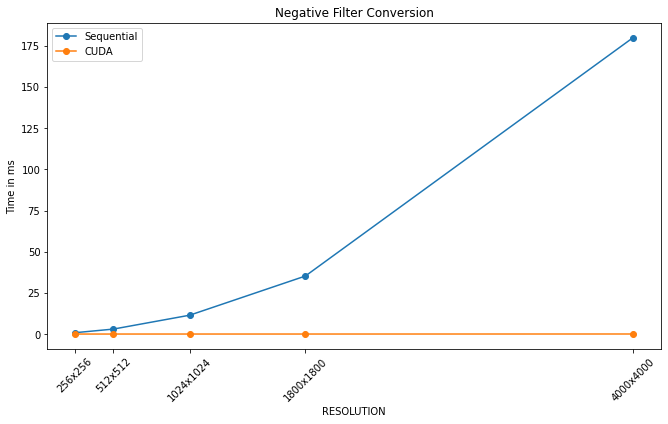

In [ ]:
plot_comparison(t_neg_seq,t_neg_p,'Negative Filter Conversion')

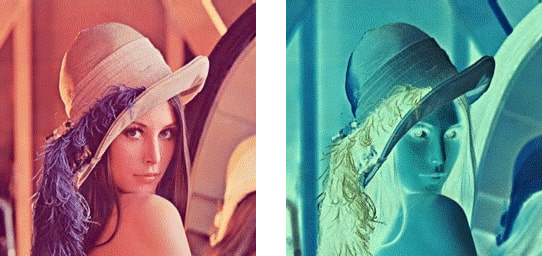

In [ ]:
adj_show(images['256'],out_neg_seq['256'])

In [ ]:
def thresholding_sequential(img,threshold):           #Sequential
  G_th = []
  for i in range(img.shape[0]):
    l = []
    for j in range(img.shape[1]):
      l.append(255 if img[i][j] >= threshold else 0)
    G_th.append(l)
  G_th = np.array(G_th)
  return G_th

In [ ]:
@numba.jit('float64[:,:](float64[:,:],float64[:,:],uint8)')             #Using CUDA jit decorator
def thresholding_parallel(img,out,threshold):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j] >= threshold:
        out[i,j] = 255.0
      else:
        out[i,j] = 0.0

  return out

In [ ]:
#Calculating time (Sequential) - Thresholding
t_thr_seq = {}
out_thr_seq = {}
for name,image in out_gray_seq.items():
  start = time.time()
  out_thr_seq[name]=thresholding_sequential(out_gray_seq[name],threshold)
  t_thr_seq[name] =  time.time() - start
t_thr_seq

{'1024': 0.7951126098632812,
 '1800': 2.469658374786377,
 '256': 0.06364774703979492,
 '4000': 12.396832704544067,
 '512': 0.20124197006225586}

In [ ]:
#Calculating time (Parallel) - Thresholding
t_thr_p = {}
out_thr_p = {}
for name,image in out_gray_seq.items():
  start = time.time()
  output = np.empty_like(out_gray_seq[name])
  out_thr_p[name]=thresholding_parallel(out_gray_seq[name],output,threshold)
  t_thr_p[name] =  time.time() - start
t_thr_p

{'1024': 0.0026543140411376953,
 '1800': 0.006542205810546875,
 '256': 0.0006124973297119141,
 '4000': 0.03194785118103027,
 '512': 0.000782012939453125}

Average Speedup: 374x


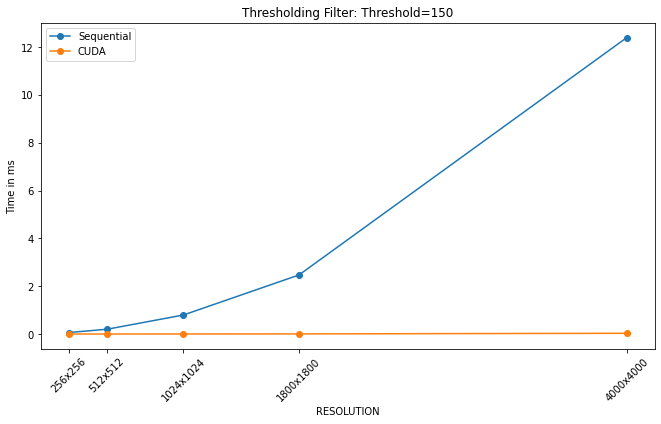

In [ ]:
plot_comparison(t_thr_seq,t_thr_p,'Thresholding Filter: Threshold={}'.format(threshold))

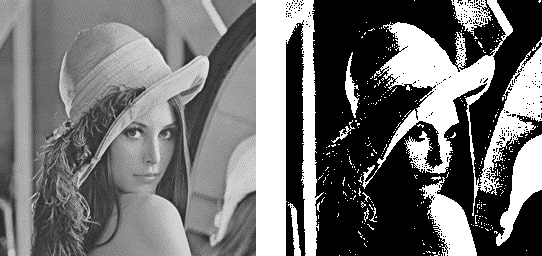

In [ ]:
adj_show(out_gray_seq['256'],out_thr_seq['256'])

In [ ]:
def brightening_sequential(img,lamb):       # Sequential
  BI = []
  ki = math.pi/(2*lamb)
  for i in range(img.shape[0]):
    l = []
    for j in range(img.shape[1]):
      q = []
      for k in range(img.shape[2]):
        q.append(lamb * math.sin(ki*img[i][j][k]))
      l.append(q)
    BI.append(l)
  BI = np.array(BI)
  return BI
  

In [ ]:
@cp.fuse()                                       #CuPY FUSE decorator for creating CUDA Kernel
def brightening_parallel(img,lamb):
  xp = cp.get_array_module(img)
  ki = xp.pi/(2*lamb)
  return lamb * xp.sin(ki*img)

In [ ]:
#Calculating time (Sequential) - Brightening
t_BI_seq = {}
out_BI_seq = {}
for name,image in images.items():
  start = time.time()
  out_BI_seq[name]=brightening_sequential(images[name],lamb)
  t_BI_seq[name] =  time.time() - start
t_BI_seq

{'1024': 12.347655534744263,
 '1800': 39.30831027030945,
 '256': 0.8015825748443604,
 '4000': 198.74712896347046,
 '512': 3.17474365234375}

In [ ]:
#Calculating time (Parallel) - Brightening
t_BI_p = {}
out_BI_p = {}
for name,image in images.items():
  start = time.time()
  im_gpu = cp.asarray(images[name])
  out_gpu=brightening_parallel(im_gpu,lamb)
  out_BI_p[name] = out_gpu.get()
  t_BI_p[name] =  time.time() - start
t_BI_p

{'1024': 0.005420684814453125,
 '1800': 0.015310287475585938,
 '256': 0.0017654895782470703,
 '4000': 0.07205343246459961,
 '512': 0.0022003650665283203}

Average Speedup: 2629x


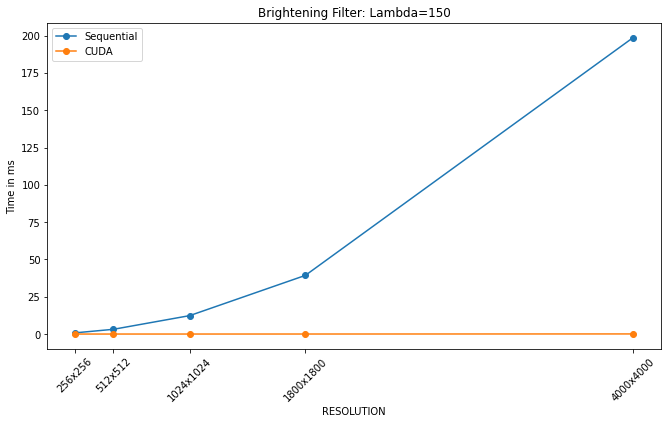

In [ ]:
plot_comparison(t_BI_seq,t_BI_p,'Brightening Filter: Lambda={}'.format(lamb))

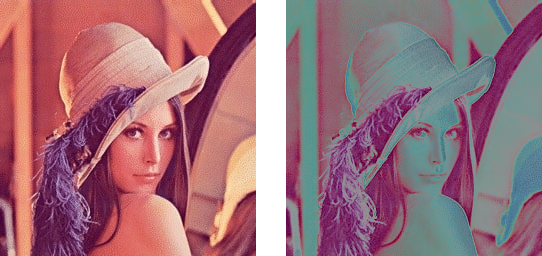

In [ ]:
adj_show(images['256'],out_BI_seq['256'])

In [ ]:
def darkening_sequential(img,lamb):             #Sequential
  DI = []
  ki = math.pi/(2*lamb)
  for i in range(img.shape[0]):
    l = []
    for j in range(img.shape[1]):
      q = []
      for k in range(img.shape[2]):
        q.append(lamb * (1-math.cos(ki*img[i][j][k])))
      l.append(q)
    DI.append(l)
  DI = np.array(DI)
  return DI

In [ ]:
@cp.fuse()                                      #CuPY FUSE decorator for creating CUDA Kernel
def darkening_parallel(img,lamb):
  xp = cp.get_array_module(img)
  ki = xp.pi/(2*lamb)
  return lamb * (1-xp.cos(ki*img))

In [ ]:
#Calculating time (Sequential) - Darkening
t_DI_seq = {}
out_DI_seq = {}
for name,image in images.items():
  start = time.time()
  out_DI_seq[name]=darkening_sequential(images[name],lamb)
  t_DI_seq[name] =  time.time() - start
t_DI_seq

{'1024': 12.681961059570312,
 '1800': 39.3860080242157,
 '256': 0.8224101066589355,
 '4000': 202.47585248947144,
 '512': 3.215050220489502}

In [ ]:
#Calculating time (Parallel) - Darkening
t_DI_p = {}
out_DI_p = {}
for name,image in images.items():
  start = time.time()
  im_gpu = cp.asarray(images[name])
  out_gpu=darkening_parallel(im_gpu,lamb)
  out_DI_p[name] = out_gpu.get()
  t_DI_p[name] =  time.time() - start
t_DI_p

{'1024': 0.011407613754272461,
 '1800': 0.03270864486694336,
 '256': 0.258894681930542,
 '4000': 0.15189790725708008,
 '512': 0.002102375030517578}

Average Speedup: 565x


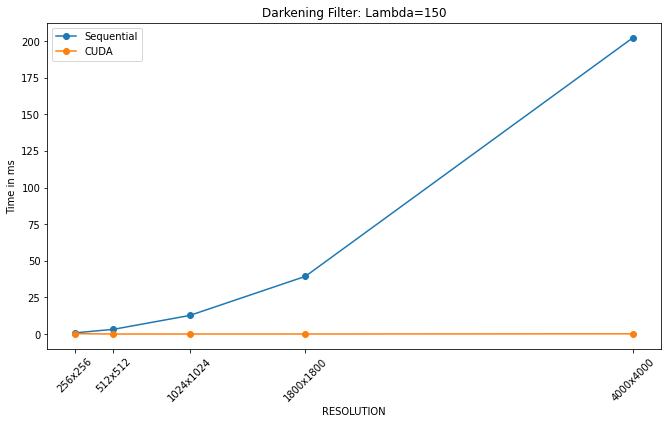

In [ ]:
plot_comparison(t_DI_seq,t_DI_p,'Darkening Filter: Lambda={}'.format(lamb))

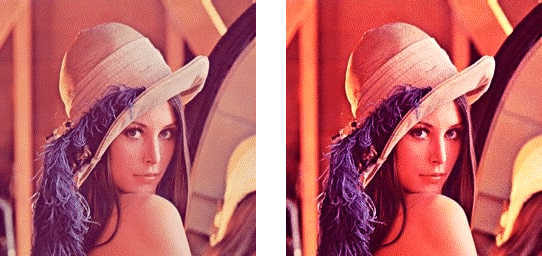

In [ ]:
adj_show(images['256'],out_DI_seq['256'])

In [ ]:
#Inverse Sinusoidal Contrast Image
def isci_sequential(img,lamb):
  ISCI = []
  ki = (2*math.pi)/255
  for i in range(img.shape[0]):
    l = []
    for j in range(img.shape[1]):
      q = []
      for k in range(img.shape[2]):
        q.append(img[i][j][k] - lamb*math.sin(ki*img[i][j][k]))
      l.append(q)
    ISCI.append(l)
  ISCI = np.array(ISCI)
  return ISCI

In [ ]:
@cp.fuse()                              #CuPY FUSE decorator for creating CUDA Kernel
def isci_parallel(img,lamb):
  xp = cp.get_array_module(img)
  ki = (2*xp.pi)/255.0
  return img - lamb*xp.sin(ki*img)

In [ ]:
#Calculating time (Sequential) - Inverse Sinusoidal Contrast
t_isci_seq = {}
out_isci_seq = {}
for name,image in images.items():
  start = time.time()
  out_isci_seq[name]=isci_sequential(images[name],lamb)
  t_isci_seq[name] =  time.time() - start
t_isci_seq

{'1024': 23.350435495376587,
 '1800': 73.1864607334137,
 '256': 1.6345601081848145,
 '4000': 361.66884756088257,
 '512': 5.962048053741455}

In [ ]:
#Calculating time (Parallel) - Inverse Sinusoidal Contrast
t_isci_p = {}
out_isci_p = {}
for name,image in images.items():
  start = time.time()
  im_gpu = cp.asarray(images[name])
  out_gpu=isci_parallel(im_gpu,lamb)
  out_isci_p[name] = out_gpu.get()
  t_isci_p[name] =  time.time() - start
t_isci_p

{'1024': 0.011399030685424805,
 '1800': 0.03336048126220703,
 '256': 0.2755134105682373,
 '4000': 0.15817666053771973,
 '512': 0.0017621517181396484}

Average Speedup: 969x


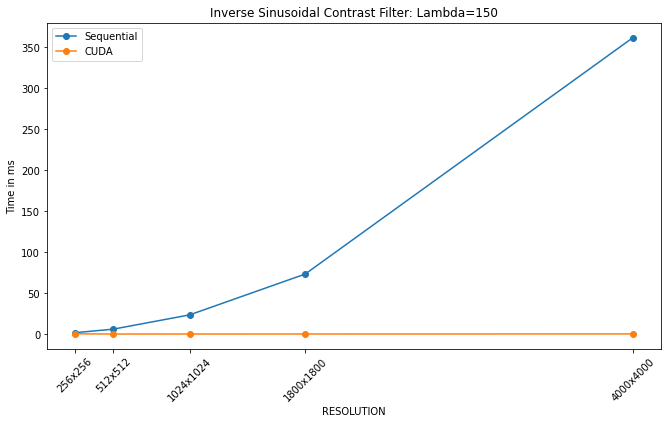

In [ ]:
plot_comparison(t_isci_seq,t_isci_p,'Inverse Sinusoidal Contrast Filter: Lambda={}'.format(lamb))

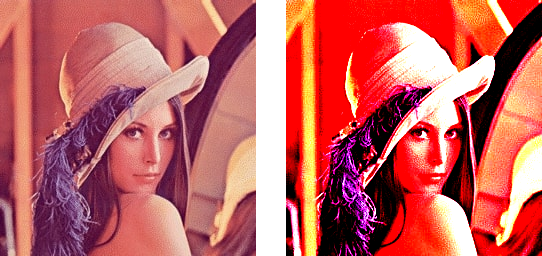

In [ ]:
adj_show(images['256'],out_isci_seq['256'])

In [ ]:
#Hyperbolic Tangent Contrast Image
def htci_sequential(img):                    #Sequential
  HTCI = []
  ki = 255/2
  start_time = time.time()
  for i in range(img.shape[0]):
    l = []
    for j in range(img.shape[1]):
      q = []
      for k in range(img.shape[2]):
        q.append(ki * (1 + math.tanh( img[i][j][k]-ki ) ))
      l.append(q)
    HTCI.append(l)
  HTCI = np.array(HTCI)
  return HTCI

In [ ]:
@cp.fuse()                                          #CuPY FUSE decorator for creating CUDA Kernel
def htci_parallel(img):
  xp = cp.get_array_module(img)
  ki = 255.0/2.0
  return ki*(1+xp.tanh(img-ki))

In [ ]:
#Calculating time (Sequential) - Hyperbolic Tangent
t_htci_seq = {}
out_htci_seq = {}
for name,image in images.items():
  start = time.time()
  out_htci_seq[name]=htci_sequential(images[name])
  t_htci_seq[name] =  time.time() - start
t_htci_seq

{'1024': 14.591115951538086,
 '1800': 46.05874705314636,
 '256': 0.9062047004699707,
 '4000': 224.9118881225586,
 '512': 3.6224205493927}

In [ ]:
#Calculating time (Parallel) - Hyperbolic Tangent
t_htci_p = {}
out_htci_p = {}
for name,image in images.items():
  start = time.time()
  im_gpu = cp.asarray(images[name])
  out_gpu=htci_parallel(im_gpu)
  out_htci_p[name] = out_gpu.get()
  t_htci_p[name] =  time.time() - start
t_htci_p

{'1024': 0.011960983276367188,
 '1800': 0.033747196197509766,
 '256': 0.25769758224487305,
 '4000': 0.1598987579345703,
 '512': 0.002249002456665039}

Average Speedup: 623x


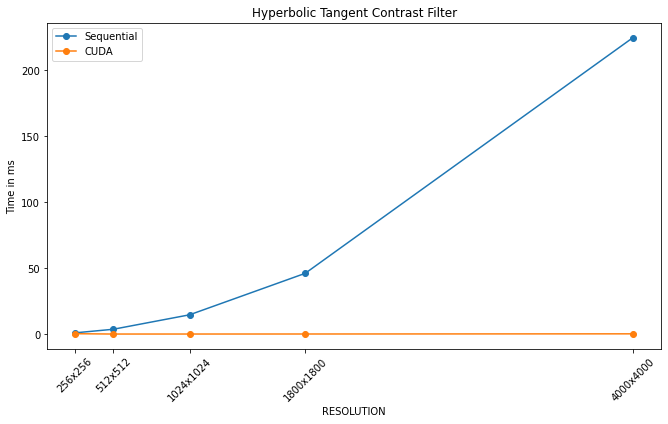

In [ ]:
plot_comparison(t_htci_seq,t_htci_p,'Hyperbolic Tangent Contrast Filter')

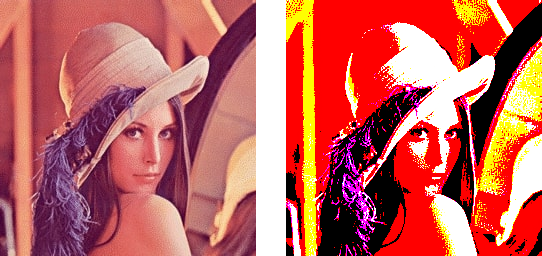

In [ ]:
adj_show(images['256'],out_htci_p['256'],)

In [ ]:
# def tryneg(img):
#   return 255-img

In [ ]:
# @cp.fuse()
# def tryneg_p(img):
#   return 255-img

In [ ]:
# t_tryneg_seq = {}
# out_tryneg_seq = {}
# for name,image in images.items():
#   start = time.time()
#   out_tryneg_seq[name]=tryneg(images[name])
#   t_tryneg_seq[name] =  time.time() - start
# t_tryneg_seq

{'1024': 0.0007772445678710938,
 '1800': 0.002365589141845703,
 '256': 0.00034332275390625,
 '4000': 0.01846456527709961,
 '512': 0.000316619873046875}

In [ ]:
# t_tryneg_p = {}
# out_tryneg_p = {}
# for name,image in images.items():
#   im_gpu = cp.asarray(images[name])
#   start = time.time()
  
#   out_gpu=tryneg_p(im_gpu)
  
#   t_tryneg_p[name] =  time.time() - start
#   out_tryneg_p[name] = out_gpu.get()
# t_tryneg_p

{'1024': 9.393692016601562e-05,
 '1800': 6.699562072753906e-05,
 '256': 0.00011205673217773438,
 '4000': 8.678436279296875e-05,
 '512': 6.651878356933594e-05}

Average Speedup: 52x


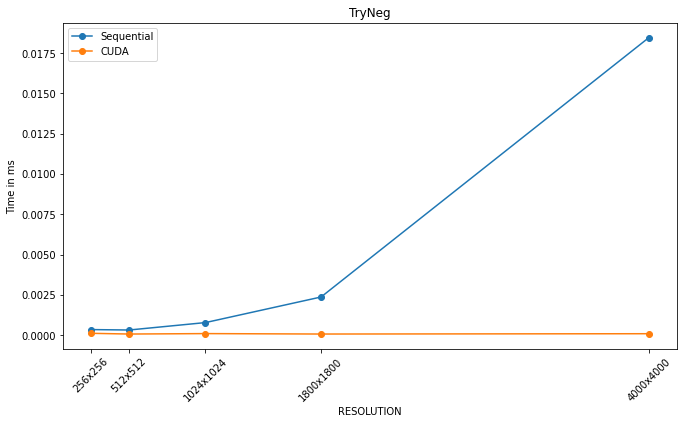

In [ ]:
# plot_comparison(t_tryneg_seq,t_tryneg_p,'TryNeg')

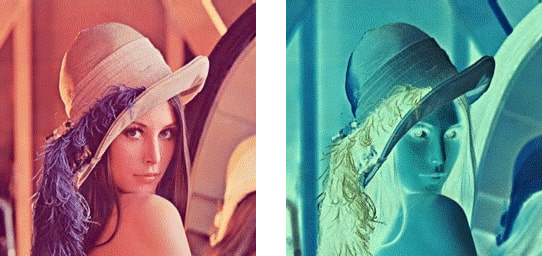

In [ ]:
# adj_show(images['256'],out_tryneg_p['256'])